In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-bike-share/bike_sharing_daily (1).csv


In [2]:
!pip install 'u8darts'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 98.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.6 MB/s eta 0:00:00
  Attempting uni

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel , TFTModel
from darts.metrics import mape
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from sklearn.model_selection import ParameterGrid
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf,month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
df = pd.read_csv("/kaggle/input/daily-bike-share/bike_sharing_daily (1).csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
df.rename(columns = {'dteday':'ds',
                    'cnt' : 'y'}, inplace = True)

In [7]:
df.columns

Index(['instant', 'ds', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'y'],
      dtype='object')

In [8]:
df.drop(['yr','mnth','instant',
        'casual', 'registered'], axis = 1, inplace = True)

In [9]:
df['ds'] = pd.to_datetime(df['ds'])

In [10]:
df.set_index('ds', inplace = True)

In [11]:
df = df.asfreq('D')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Freq: D
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   holiday     731 non-null    int64  
 2   weekday     731 non-null    int64  
 3   workingday  731 non-null    int64  
 4   weathersit  731 non-null    int64  
 5   temp        731 non-null    float64
 6   atemp       731 non-null    float64
 7   hum         731 non-null    float64
 8   windspeed   731 non-null    float64
 9   y           731 non-null    int64  
dtypes: float64(4), int64(6)
memory usage: 62.8 KB


# EDA

<Axes: xlabel='ds'>

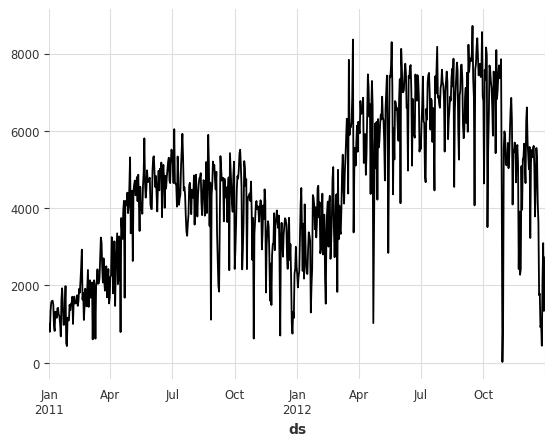

In [13]:
df['y'].plot()

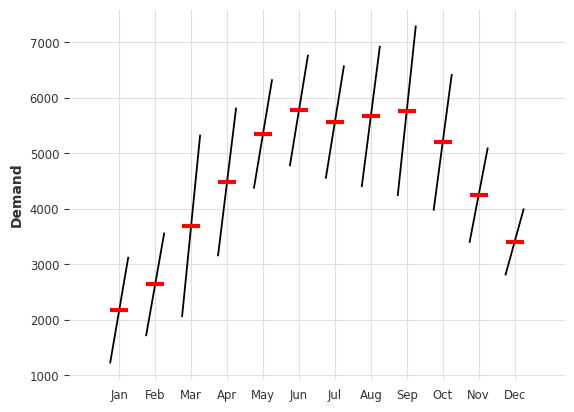

In [14]:
month_plot(df['y'].resample("ME").mean() , ylabel = "Demand")
plt.show()

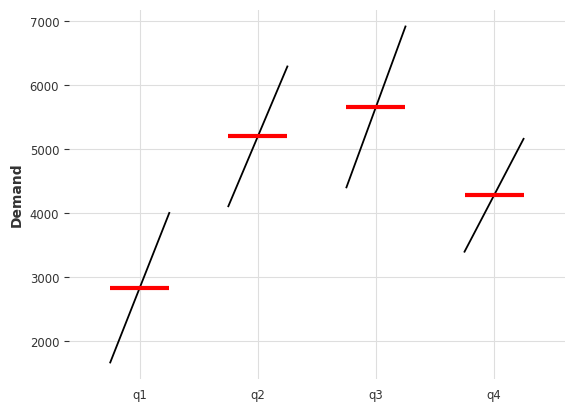

In [15]:
quarter_plot(df['y'].resample('QE').mean(), ylabel = 'Demand')
plt.show()

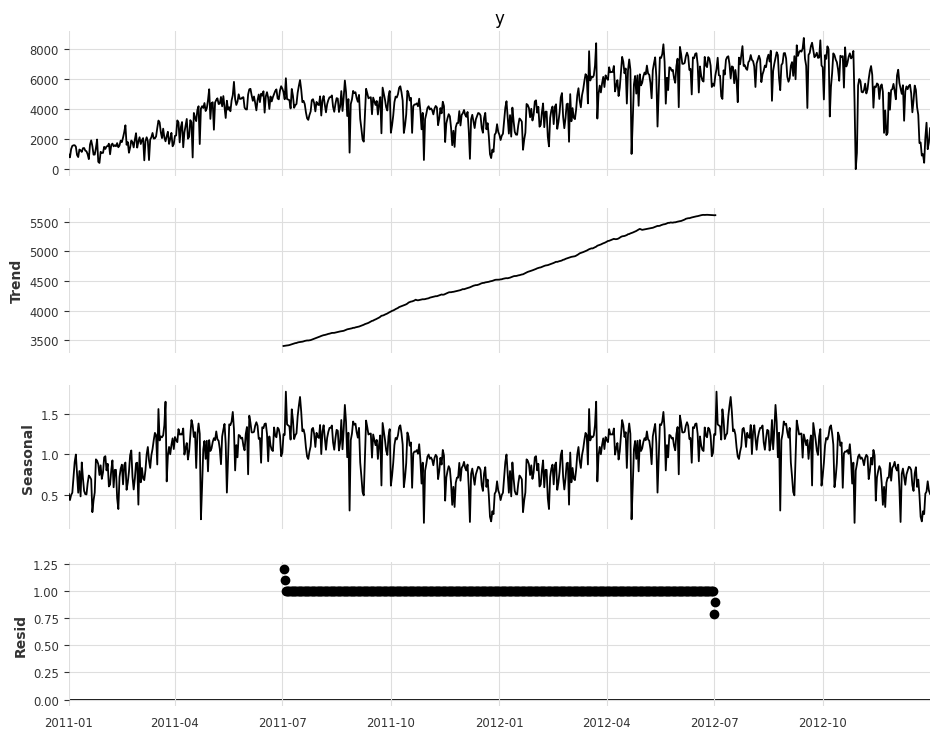

In [16]:
decomposition = seasonal_decompose(df['y'] , model = 'mul' , period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
fig.show()

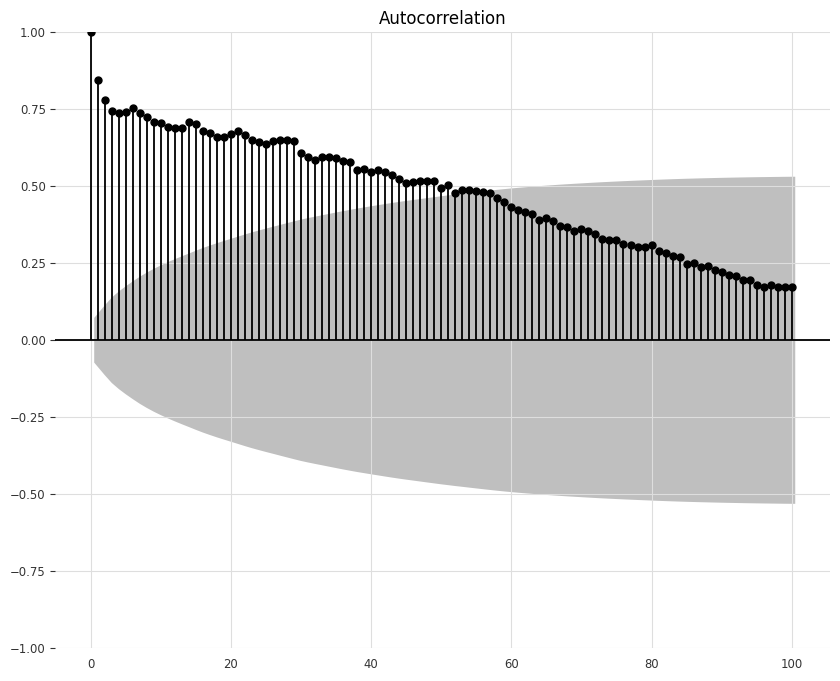

In [17]:
plt.rc("figure" ,figsize = (10,8))
plot_acf(df['y'] , lags = 100)
plt.show()

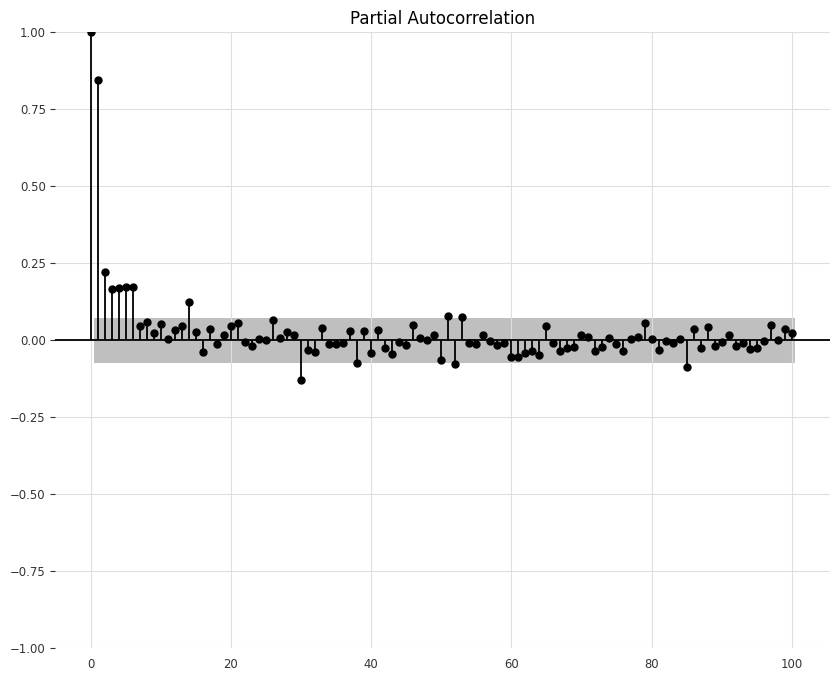

In [18]:
plt.rc("figure" ,figsize = (10,8))
plot_pacf(df['y'] , lags = 100)
plt.show()

# Data Preprocessing

In [19]:
df_future = df.iloc[-31:,:]
df = df.iloc[:-31 , ]

In [20]:
series = TimeSeries.from_series(df['y'])

In [21]:
train , val = series.split_after(pd.Timestamp("20121031"))

In [23]:
scaler1 = Scaler()
train_transformed = scaler1.fit_transform(train)
val_transformed  = scaler1.transform(val)
series_transformed = scaler1.transform(series)

In [24]:
year_series = datetime_attribute_timeseries(
    pd.date_range(start = series.start_time(),
                 freq = series.freq_str,
                 periods = len(series)),
    attribute = "year",
    one_hot = False
)

year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series,
    attribute = 'month',
    one_hot = True
)

weekday_series = datetime_attribute_timeseries(year_series,
                                             attribute = 'weekday',
                                             one_hot = True)

In [25]:
df.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,y
ds,,,,,,,,,,
2011-01-01,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
2011-01-02,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2011-01-03,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
2011-01-04,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
2011-01-05,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [26]:
# Covaraites
covariates_1 = TimeSeries.from_dataframe(df.iloc[:,0:9])
covariates_transformed = Scaler().fit_transform(covariates_1)

In [27]:
covariates_2 = year_series.stack(month_series).stack(weekday_series)

In [28]:
covariates_transformed = covariates_transformed.stack(covariates_2)

In [29]:
TimeSeries.to_dataframe(covariates_transformed)

component,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,year,...,month_9,month_10,month_11,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
ds,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.0,0.0,1.000000,0.0,0.5,0.355170,0.373517,0.828620,0.284606,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-02,0.0,0.0,0.000000,0.0,0.5,0.379232,0.360541,0.715771,0.466215,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-03,0.0,0.0,0.166667,1.0,0.0,0.171000,0.144830,0.449638,0.465740,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.333333,1.0,0.0,0.175530,0.174649,0.607131,0.284297,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.500000,1.0,0.0,0.209120,0.197158,0.449313,0.339143,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-26,1.0,0.0,0.166667,1.0,0.0,0.316749,0.341199,0.550557,0.050010,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-11-27,1.0,0.0,0.333333,1.0,0.5,0.289752,0.265793,0.808912,0.443585,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-11-28,1.0,0.0,0.500000,1.0,0.0,0.295982,0.276562,0.520566,0.388457,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# RNN Model

In [61]:
# RNNModel

model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers = 1,
    dropout=0.0,
    batch_size=30,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    random_state= 42,
    training_length=20,
    input_chunk_length= 10,
    save_checkpoints=True,
    pl_trainer_kwargs = {'accelerator' : 'gpu',
                            'devices' : 1,
                        'enable_progress_bar' : False}
)

In [62]:
model.fit(
    train_transformed,
    future_covariates = covariates_transformed,
    val_series = val_transformed,
    val_future_covariates = covariates_transformed,
    verbose = False
)

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=20, batch_size=30, n_epochs=50, optimizer_kwargs={'lr': 0.001}, random_state=42, input_chunk_length=10, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1, 'enable_progress_bar': False})

In [63]:
pred_series = model.predict(n = len(val) ,
                           future_covariates = covariates_transformed,
                           verbose = False)

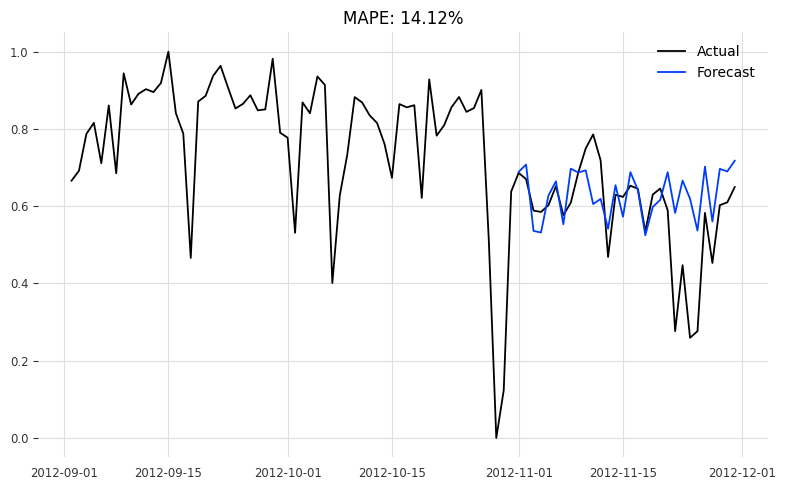

In [64]:
_ , series_transformed_slice = series_transformed.split_after(pd.Timestamp("20120901"))

plt.figure(figsize=(8, 5))

# Plot actual values
plt.plot(series_transformed_slice.time_index, series_transformed_slice.values(), label="Actual")

# Plot forecasted values
plt.plot(pred_series.time_index, pred_series.values(), label="Forecast")

# Add title with MAPE
plt.title(f"MAPE: {mape(pred_series, val_transformed):.2f}%")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Cross Validation

In [65]:
cv = model.historical_forecasts(series = series_transformed,
                               future_covariates = covariates_transformed,
                               start = df.shape[0] - 150,
                               forecast_horizon = len(val),
                               stride = 30,
                               retrain = True,
                               last_points_only = False,
                                verbose = False
                               )

In [45]:
from darts.metrics import mape

In [66]:
from sklearn.metrics import mean_squared_error

rmse_cv = []

for i in range(len(cv)):
    
    predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))
    
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df.y[start:end ,]
    
    error_cv = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_cv.append(error_cv)

print(np.mean(rmse_cv))

991.3949087151202


In [67]:
param_grid = {'n_rnn_layers' : [1],
             'hidden_dim' : [20],
             'dropout' : [0.0,],
             'n_epochs' : [50],
             'lr' : [0.003],
             'training_length' : [25,20], # 31+46
             'input_chunk_length' : [10,15]
             }

grid = ParameterGrid(param_grid)
len(list(grid))

4

In [69]:
# Parameter Tuning Loop

rmse = []

for params in grid:

   # Build the model
    model = RNNModel(model = 'LSTM',
                    hidden_dim = params['hidden_dim'],
                    n_rnn_layers = params['n_rnn_layers'],
                    dropout = params['dropout'],
                    n_epochs = params['n_epochs'],
                    optimizer_kwargs = {'lr' : 0.003},
                    random_state = 1502 ,
                    training_length = params['training_length'],
                    input_chunk_length = params['input_chunk_length'],
                    save_checkpoints=True,
                    pl_trainer_kwargs = {'accelerator' : 'gpu',
                                            'devices' : 1,
                                        'enable_progress_bar' : False}
                
                  ) 

    
    model.fit(series_transformed, 
              future_covariates= covariates_transformed,
             verbose = False)
    
    # Cross Validation with rollling window
    
    cv = model.historical_forecasts(series = series_transformed,
                                   future_covariates = covariates_transformed,
                                   start = df.shape[0] -180,
                                   forecast_horizon = len(val),
                                   stride = 30,
                                   retrain = True,
                                   verbose = False,
                                   last_points_only = False)

    rmse_cv = []
    
    for i in range(len(cv)):
    
        predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

        # Actuals
        start = predictions.index.min()
        end = predictions.index.max()
        actuals = df.y[start:end , ]

        # Compute the error
        error_cv = np.sqrt(mean_squared_error(actuals , predictions))
        rmse_cv.append(error_cv)
        
  # Calculating and storing the error
    error = np.mean(rmse_cv)
    rmse.append(error)
        

In [70]:
print(np.mean(rmse))

1308.2969424572


In [71]:
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,dropout,hidden_dim,input_chunk_length,lr,n_epochs,n_rnn_layers,training_length,rmse
0,0.0,20,10,0.003,50,1,25,1348.819329
1,0.0,20,10,0.003,50,1,20,1268.042571
2,0.0,20,15,0.003,50,1,25,1347.717826
3,0.0,20,15,0.003,50,1,20,1268.608044


In [72]:
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()]
best_params = best_params.iloc[0,:]
best_params.to_csv("best_params_round1.csv")

In [73]:
params_round1 = pd.read_csv("best_params_round1.csv", index_col = 0)
params_round1

,1
dropout,0.000000
hidden_dim,20.000000
input_chunk_length,10.000000
lr,0.003000
n_epochs,50.000000
n_rnn_layers,1.000000
training_length,20.000000
rmse,1268.042571


In [74]:
hidden_dim = int(params_round1.loc['hidden_dim'].iloc[0])
n_rnn_layers = int(params_round1.loc['n_rnn_layers'].iloc[0])
dropout = params_round1.loc['dropout'].iloc[0]
n_epochs = int(params_round1.loc['n_epochs'].iloc[0])
lr = params_round1.loc['lr'].iloc[0]
training_length = int(params_round1.loc['training_length'].iloc[0])
input_chunk_length = int(params_round1.loc['input_chunk_length'].iloc[0])

In [81]:
df_future.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,y
ds,,,,,,,,,,
2012-12-01,4,0,6,0,2,0.298333,0.316904,0.806667,0.059704,5191
2012-12-02,4,0,0,0,2,0.347500,0.359208,0.823333,0.124379,4649
2012-12-03,4,0,1,1,1,0.452500,0.455796,0.767500,0.082721,6234
2012-12-04,4,0,2,1,1,0.475833,0.469054,0.733750,0.174129,6606
2012-12-05,4,0,3,1,1,0.438333,0.428012,0.485000,0.324021,5729


In [82]:
X = pd.concat([df , df_future])

In [83]:
series = TimeSeries.from_series(X['y'])

In [84]:
train , val = series.split_after(pd.Timestamp("20121130"))

In [85]:
train_transformed = scaler1.fit_transform(train)
val_transformed  = scaler1.transform(val)
series_transformed = scaler1.transform(series)

In [86]:
# Year 
year_series = datetime_attribute_timeseries(
    pd.date_range(start = series.start_time(),
                 freq = series.freq_str,
                 periods = X.shape[0]),
    attribute = 'year',
    one_hot = False)

year_series = Scaler().fit_transform(year_series)
# Month
month_series = datetime_attribute_timeseries(year_series,
                                            attribute = 'month',
                                            one_hot = True)

# Weekday
weekday_series = datetime_attribute_timeseries(year_series,
                                            attribute = 'weekday',
                                            one_hot = True)

In [87]:
covariates_1 = TimeSeries.from_dataframe(X.iloc[:,0:9])
covariates_transformed = Scaler().fit_transform(covariates_1)

In [88]:
covariates_2 = year_series.stack(month_series).stack(weekday_series)

In [90]:
covariates_transformed = covariates_transformed.stack(covariates_2)

In [91]:
TimeSeries.to_dataframe(covariates_transformed)

component,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,year,...,month_9,month_10,month_11,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
ds,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.0,0.0,1.000000,0.0,0.5,0.355170,0.373517,0.828620,0.284606,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-02,0.0,0.0,0.000000,0.0,0.5,0.379232,0.360541,0.715771,0.466215,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-03,0.0,0.0,0.166667,1.0,0.0,0.171000,0.144830,0.449638,0.465740,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.333333,1.0,0.0,0.175530,0.174649,0.607131,0.284297,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.500000,1.0,0.0,0.209120,0.197158,0.449313,0.339143,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,0.0,0.0,0.666667,1.0,0.5,0.243025,0.193709,0.671380,0.675656,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-12-28,0.0,0.0,0.833333,1.0,0.5,0.241986,0.230993,0.606684,0.274350,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-12-29,0.0,0.0,1.000000,0.0,0.5,0.241986,0.214393,0.774208,0.210260,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [92]:
model = RNNModel(model = 'LSTM',
                hidden_dim = hidden_dim,
                n_rnn_layers = n_rnn_layers ,
                dropout = dropout,
                n_epochs = n_epochs,
                optimizer_kwargs = {'lr': lr},
                random_state = 1502,
                training_length = training_length,
                input_chunk_length = input_chunk_length,
                pl_trainer_kwargs = {'accelerator' : 'gpu',
                                     'devices' : 1,
                                     'enable_progress_bar' : False}
               ) 
                

In [93]:
model.fit(train_transformed, 
          future_covariates = covariates_transformed,
         verbose = False)

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=20, n_epochs=50, optimizer_kwargs={'lr': 0.003}, random_state=1502, input_chunk_length=10, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1, 'enable_progress_bar': False})

In [94]:
pred_series = model.predict(n = len(val),
                           future_covariates = covariates_transformed,
                           verbose = False)


In [95]:
_ , series_transformed_slice = series_transformed.split_after(pd.Timestamp("20120901"))

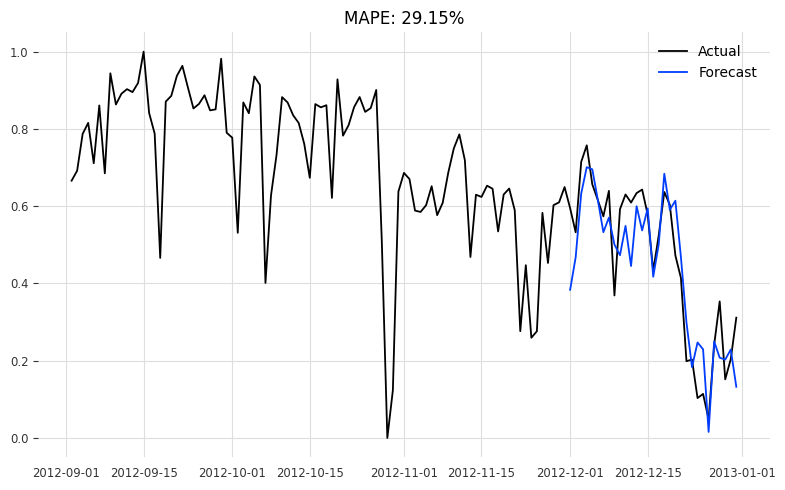

In [96]:
import matplotlib.pyplot as plt
from darts.metrics import mape

plt.figure(figsize=(8, 5))

# Plot actual values
plt.plot(series_transformed_slice.time_index, series_transformed_slice.values(), label="Actual")

# Plot forecasted values
plt.plot(pred_series.time_index, pred_series.values(), label="Forecast")

# Add title with MAPE
plt.title(f"MAPE: {mape(pred_series, val_transformed):.2f}%")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
